In [236]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls ./drive/MyDrive/image_classification_telkom/

archive.zip  images


In [5]:
!sudo apt-get install unzip
!cd /drive/MyDrive/image_classification_telkom/image
!unzip ./drive/MyDrive/image_classification_telkom/archive.zip 
#-d ./drive/MyDrive/image_classification_telkom/

Streaming output truncated to the last 5000 lines.
  inflating: images/images/travel and  adventure/Places365_val_00009663.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009664.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009665.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009666.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009667.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009668.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009669.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009670.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009671.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009672.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009673.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009674.jpg  
  inflating: 

In [6]:
!ls -a ./images/images

 .    architecure	'food and d rinks'
 ..  'art and culture'	'travel and  adventure'


In [19]:
!rm  -r ./images/images/.ipynb_checkpoints/
!mv ./images/images/food\ and\ d\ rinks ./images/images/food
!mv ./images/images/architecure ./images/images/architecture
!mv ./images/images/travel\ and\ \ adventure ./images/images/travel\ and\ 

mv: cannot stat './images/images/food and d rinks': No such file or directory
mv: cannot stat './images/images/architecure': No such file or directory
mv: cannot stat './images/images/travel and  adventure': No such file or directory


In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8857666049673772899
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40146370560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5250732906532679517
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


<H2>Loading the datasets from kaagle

splitting the test set to training set (80%) and validation set(20%)

In [20]:
training_set, validation_set = tf.keras.utils.image_dataset_from_directory(
    './images/images',
    labels='inferred',
    label_mode='int',
    class_names=['architecture', 'art and culture', 'food', 'travel and adventure'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="both",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 35093 files belonging to 4 classes.
Using 28075 files for training.
Using 7018 files for validation.


Using the validation set as test set because the test set provided does not have any label

In [21]:
test_set = tf.keras.utils.image_dataset_from_directory(
    './validation/validation',
    labels='inferred',
    label_mode='int',
    class_names=['architecture', 'art and culture', 'food', 'travel and adventure'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 122 files belonging to 4 classes.


Loading one of the image to test that the datasets are loaded properly


In [22]:
validation_ds = validation_set.unbatch()
# images = list(validation_ds.map(lambda x, y: x))
# labels = list(validation_ds.map(lambda x, y: y))

In [24]:
validation_set.class_names

['architecture', 'art and culture', 'food', 'travel and adventure']

In [27]:
list(validation_ds)[0][1]

<tf.Tensor: shape=(), dtype=int32, numpy=3>

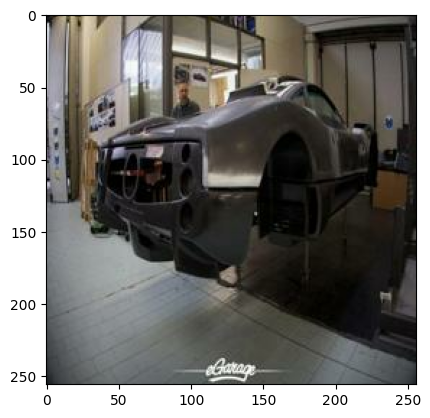

In [28]:
plt.imshow(tf.dtypes.cast(list(validation_ds)[0][0], tf.int32))
plt.show()

<H2> Data augmentation

Creating random flip and rotation to train image to augment new training data and allow the model to better generalize to different images


In [61]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


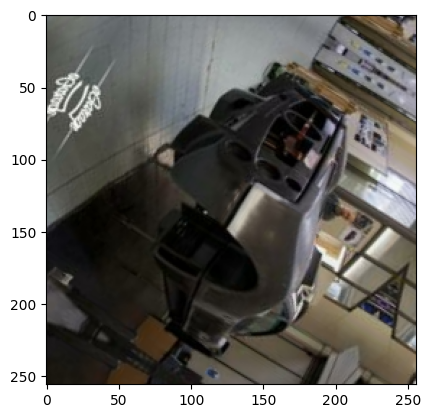

In [64]:
plt.imshow(tf.dtypes.cast(data_augmentation(list(validation_ds)[0][0]), tf.int32))
plt.show()

Map the image augmentator to the train dataset and append the images to the training set

In [65]:
aug_ds = training_set.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [90]:
combined_train_set = training_set.concatenate(aug_ds)

<H2> Training VGG pre-trained model on dataset

Use mixed float to reduce training time by decreasing precision due to limited resources

In [97]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [176]:
import keras
from keras.applications.vgg16 import VGG16
# load model
model = keras.models.Sequential()
vgg_model =  VGG16(include_top=False, input_shape=(256, 256,3))
for layer in vgg_model.layers:
  layer.trainable = False
for layer in vgg_model.layers:
  print(layer.name, layer.trainable)
model.add(vgg_model)
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(10, activation = "relu"))
model.add(keras.layers.Dense(4, activation = "softmax"))
# summarize the model
model.summary()

input_19 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 32768)             0         
                                                                 
 dense_21 (Dense)            (None, 4)                 131076    
                                                                 
Total params: 14,845,764
Trainable params: 131,076
Non-trainable params: 14,714,688
_____________

In [228]:
opt = keras.optimizers.Adam(learning_rate=0.05)
model.compile(
  optimizer=opt,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Preprocess the tensor for VGG16 

In [229]:
combined_train_set_vgg =combined_train_set.map (lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x),y))

In [230]:
validation_set_vgg =validation_set.map (lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x),y))

In [234]:
test_set_vgg =test_set.map (lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x),y))

In [ ]:
model.fit(
  combined_train_set_vgg,
  validation_data= validation_set_vgg,
  epochs=3
)


Epoch 1/3
1756/1756 [==============================] - 278s 158ms/step - loss: nan - accuracy: 0.8708 - val_loss: nan - val_accuracy: 0.8408
Epoch 2/3
1756/1756 [==============================] - 278s 158ms/step - loss: nan - accuracy: 0.8645 - val_loss: nan - val_accuracy: 0.8720
Epoch 3/3
1451/1756 [=======================>......] - ETA: 39s - loss: nan - accuracy: 0.8814

In [223]:
model.save('./drive/MyDrive/image_classification_telkom/vgg_best_model_keras')

<H2> Getting performance VGG16 on Test Set

In [246]:
test_scores = model.evaluate(test_set_vgg, verbose=2)

4/4 - 0s - loss: nan - accuracy: 0.9098 - 334ms/epoch - 84ms/step


<H2>Sample Prediction using VGG16

In [247]:
test_label_prob = model.predict(test_set_vgg, verbose=2)

4/4 - 1s - 515ms/epoch - 129ms/step


In [248]:
test_label =tf.math.argmax(test_label_prob, axis = 1)

In [249]:
test_unbatched = test_set.unbatch()

In [250]:
print(len(test_label))

122


test label 3
VGG predicted label 3


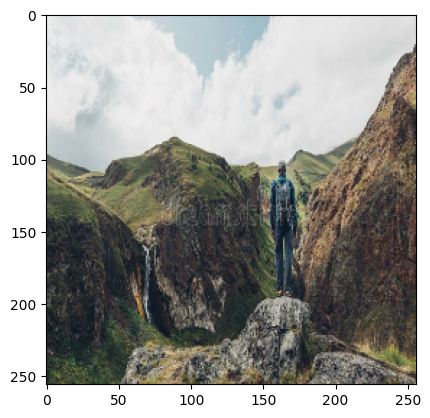

In [257]:
idx = 100
print(f'test label {list(test_unbatched)[idx][1]}')
print(f"VGG predicted label {test_label[idx]}")
plt.imshow(tf.dtypes.cast(list(test_unbatched)[idx][0], tf.int32))
plt.show()

<h2>Trying out Efficientnet

For comparison, another pretrained model which is efficientnet will be trained on the image classification dataset

In [212]:
from keras.layers import Dense, Conv2D, Flatten
model2 = keras.models.Sequential()
efficientnet_model =  tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(256, 256,3))
for layer in efficientnet_model.layers:
  layer.trainable = False

model2.add(efficientnet_model)
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(4, activation = "softmax"))
model2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 flatten_16 (Flatten)        (None, 81920)             0         
                                                                 
 dense_25 (Dense)            (None, 4)                 327684    
                                                                 
Total params: 4,377,255
Trainable params: 327,684
Non-trainable params: 4,049,571
_________________________________________________________________


preprocessing the datasets for efficient net

In [215]:
combined_train_set_efficientnet =combined_train_set.map (lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x),y))

In [216]:
val_set_efficientnet =validation_set.map (lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x),y))

In [243]:
test_set_efficient_net = test_set.map (lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x),y))

In [218]:
opt = keras.optimizers.Adam(learning_rate=0.05)
model2.compile(
  optimizer=opt,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [219]:
model2.fit(
  combined_train_set_efficientnet,
  validation_data= val_set_efficientnet,
  epochs=3
)

Epoch 1/3
1756/1756 [==============================] - 279s 154ms/step - loss: 81.3804 - accuracy: 0.9160 - val_loss: 65.5839 - val_accuracy: 0.9427
Epoch 2/3
1756/1756 [==============================] - 270s 153ms/step - loss: 70.3141 - accuracy: 0.9446 - val_loss: 90.9404 - val_accuracy: 0.9453
Epoch 3/3
1756/1756 [==============================] - 270s 153ms/step - loss: 67.3345 - accuracy: 0.9528 - val_loss: 98.4474 - val_accuracy: 0.9443


In [237]:
pickle.dump(model2, open('./drive/MyDrive/image_classification_telkom/efficientnet_best_model_keras.p', 'wb'))

<H2>Getting performance of Efficient net on test set

In [244]:
test_scores_model2 = model2.evaluate(test_set_efficient_net, verbose=2)

4/4 - 0s - loss: 410.4426 - accuracy: 0.8689 - 248ms/epoch - 62ms/step


<H2> Sample prediction using Efficient net

In [253]:
test_label_prob_efficient = model.predict(test_set_efficient_net, verbose=2)

4/4 - 0s - 233ms/epoch - 58ms/step


In [254]:
test_label_efficient =tf.math.argmax(test_label_prob_efficient, axis = 1)

In [255]:
test_unbatched = test_set.unbatch()

test label 3
efficient net predicted label 3


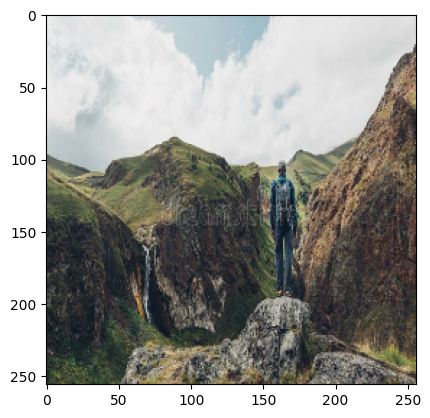

In [256]:
idx = 100
print(f'test label {list(test_unbatched)[idx][1]}')
print(f"efficient net predicted label {test_label_efficient[idx]}")
plt.imshow(tf.dtypes.cast(list(test_unbatched)[idx][0], tf.int32))
plt.show()

<h2>Performance comparison


In [263]:
import pandas as pd

In [266]:
scores = {'vgg accuracy':[test_scores[1]],'efficient net accuracy':[test_scores_model2[1]]}

In [267]:
pd.DataFrame.from_dict(scores)

,vgg accuracy,efficient net accuracy
0,0.909836,0.868852


As it can be seen efficient net despite having a higher accuracy in training performs worse in the test set compared to VGG. This means VGG is better able to generalize than efficient net. Hence, VGG is superior compared to efficient net for this photography classification task.